In [ ]:
import os
import re
import tempfile
import zipfile
from io import BytesIO

import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import rioxarray as rxr
import rioxarray.merge as rxrmerge
from pysheds.grid import Grid

data_dir = 'data'

## Area of Interest

<Axes: >

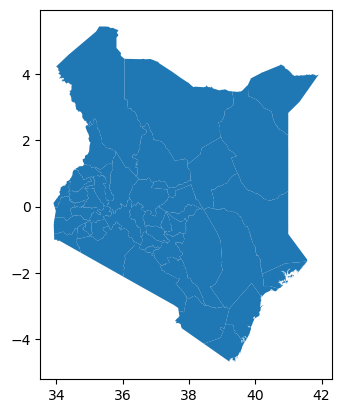

In [ ]:
kenya_url = (
    "https://open.africa"
    "/dataset/194132e2-d3b8-4c76-9eac-1bd91ebaa9ad"
    "/resource/0b78f25e-494e-4258-96b8-a3ab2b35b121"
    "/download"
    "/kenyan-counties.zip"
)
kenya_dir = os.path.join(data_dir, 'kenyan-counties')
os.makedirs(kenya_dir, exist_ok=True)
kenya_path = os.path.join(kenya_dir, 'kenyan-counties.shp')

if not os.path.exists(kenya_path):
    kenya_gdf = gpd.read_file(kenya_url)
    kenya_gdf.to_file(kenya_path)

kenya_gdf = gpd.read_file(kenya_path)

kenya_gdf.plot()

<Axes: >

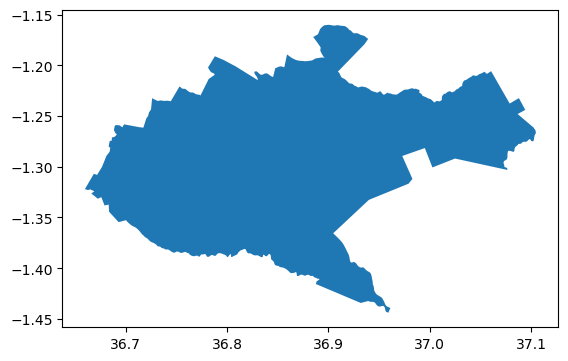

In [ ]:
# Locate counties of interest
nairobi_gdf = kenya_gdf[kenya_gdf.COUNTY=='Nairobi']
nairobi_gdf.plot()

<Axes: >

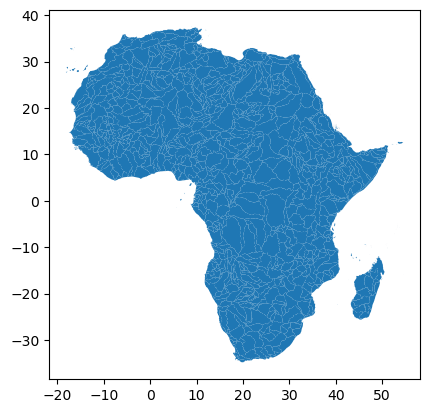

In [ ]:
basins_url = (
    "https://data.hydrosheds.org/file/hydrobasins/standard"
    "/hybas_af_lev01-12_v1c.zip"
)
basins_dir = os.path.join(data_dir, 'africa_hydrobasins')
os.makedirs(basins_dir, exist_ok=True)
basins_l5_path = os.path.join(basins_dir, 'hybas_af_lev05_v1c.shp')

if not os.path.exists(basins_l5_path):
    basins_response = requests.get(basins_url)
    with zipfile.ZipFile(BytesIO(basins_response.content)) as basins_zip:
        basins_zip.extractall(basins_dir)

basins_l5_gdf = gpd.read_file(basins_l5_path)
basins_l5_gdf.plot()

<Axes: >

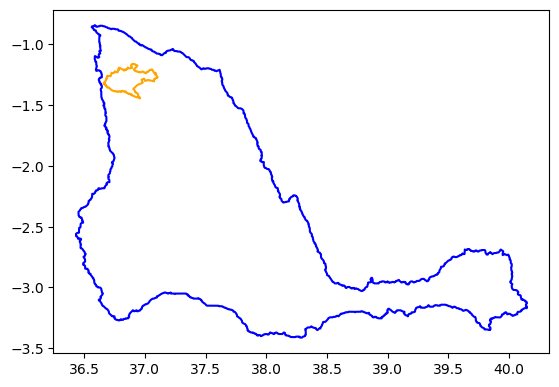

In [ ]:
# Find level 5 basin containing the boundary
nairobi_basins_l5_gdf = basins_l5_gdf.sjoin(
    nairobi_gdf, how='inner', predicate='intersects')

nairobi_basins_l5_gdf.boundary.plot(color='blue')
nairobi_gdf.boundary.plot(ax=plt.gca(), color='orange')

<Axes: >

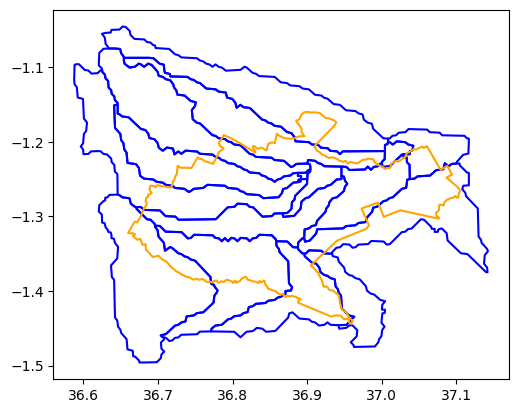

In [ ]:
# Find level 12 basins that overlap AOI
basins_l12_path = os.path.join(basins_dir, 'hybas_af_lev12_v1c.shp')
basins_l12_gdf = gpd.read_file(basins_l12_path, mask=nairobi_basins_l5_gdf)

nairobi_basins_l12_gdf = basins_l12_gdf.sjoin(
    nairobi_gdf, how='inner', predicate='intersects')

nairobi_basins_l12_gdf.boundary.plot(color='blue')
nairobi_gdf.boundary.plot(ax=plt.gca(), color='orange')

## Elevation data

In [ ]:
earthaccess.login()

In [ ]:
datasets = earthaccess.search_datasets(keyword='SRTMGL1')

for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm']['EntryTitle'])

SRTMGL1 NASA Shuttle Radar Topography Mission Global 1 arc second V003
SRTMGL3 NASA Shuttle Radar Topography Mission Global 3 arc second V003
SRTMGL1_NC NASA Shuttle Radar Topography Mission Global 1 arc second NetCDF V003
SRTMGL1N NASA Shuttle Radar Topography Mission Global 1 arc second number V003
SRTMGL1_NUMNC NASA Shuttle Radar Topography Mission Global 1 arc second Number NetCDF V003
SRTMGL3S NASA Shuttle Radar Topography Mission Global 3 arc second sub-sampled V003


In [ ]:
# Prepare data paths
elevation_dir = os.path.join(data_dir, 'srtm')
os.makedirs(elevation_dir, exist_ok=True)
elevation_path = os.path.join(elevation_dir, 'nairobi_elevation.tif')

if not os.path.exists(elevation_path):
    srtm_re = re.compile(r'(?P<tile_id>S\d+E\d+)\.SRTMGL1\.hgt\.zip$')
    bounds = tuple(nairobi_basins_l12_gdf.total_bounds)
    ea_results = earthaccess.search_data(
        short_name='SRTMGL1', bounding_box=bounds)
    elevation_files = earthaccess.open(ea_results)

    elevation_da_list = []
    for elevation_file in elevation_files:
        # Get the tile id -- this is also the file name
        tile_id = srtm_re.search(elevation_file.full_name).group('tile_id')

        # Save the file-like object to a temporary file
        with tempfile.NamedTemporaryFile(suffix=".zip") as temp_zip:
            temp_zip.write(elevation_file.read())

            full_da = (
                rxr.open_rasterio(
                    f"/vsizip/{temp_zip.name}/{tile_id}.hgt",
                    mask_and_scale=True)
                .squeeze()
            )
            cropped_da = full_da.rio.clip_box(*bounds)
            elevation_da_list.append(cropped_da)

    elevation_da = rxrmerge.merge_arrays(elevation_da_list)
    # Crop again to avoid extra rows/columnss
    elevation_da = elevation_da.rio.clip_box(*bounds)
    elevation_da.rio.to_raster(elevation_path)

elevation_da = rxr.open_rasterio(elevation_path, mask_and_scale=True).squeeze()

elevation_da 

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.DataArray (y: 1622, x: 1998)> Size: 13MB
[3240756 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16kB 36.59 36.59 36.59 36.59 ... 37.14 37.14 37.14
  * y            (y) float64 13kB -1.046 -1.046 -1.046 ... -1.495 -1.496 -1.496
    spatial_ref  int64 8B 0
Attributes:
    units:          m
    AREA_OR_POINT:  Point

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

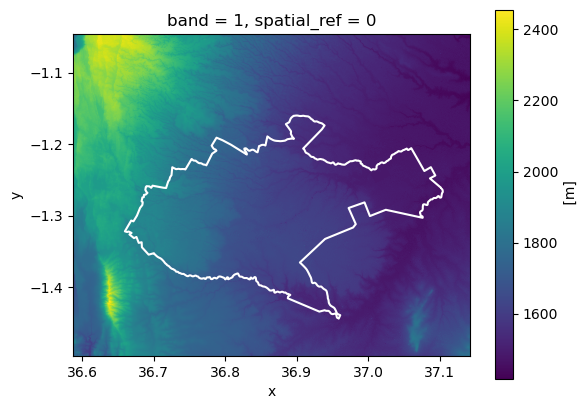

In [ ]:
elevation_da.plot()
nairobi_gdf.boundary.plot(ax=plt.gca(), color='white')

## Hydrography data

In [ ]:
# Read elevation raster
grid = Grid.from_raster(elevation_path,)
dem = grid.read_raster(elevation_path)

# Condition DEM
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem)

# Compute flow directions
fdir = grid.flowdir(inflated_dem)

# Compute accumulation
acc = grid.accumulation(fdir)

ValueError: Pour point (557, 1996) is out of bounds for dataset with shape (1622, 1998).

In [ ]:
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))

# Delineate a catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')

In [ ]:
# Compute height above nearest drainage
hand = grid.compute_hand(fdir, dem, acc < 0)

# Clip to the catchment
grid.clip_to(catch)

# Create a view of HAND in the catchment
hand_view = grid.view(hand, nodata=np.nan)

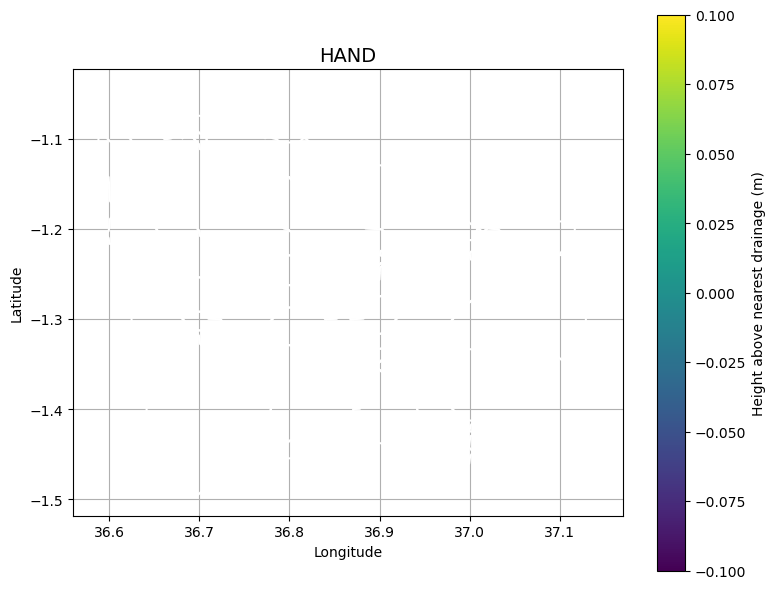

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.imshow(
    hand_view, 
    extent=grid.extent, 
    cmap='viridis',
    zorder=1)
plt.colorbar(label='Height above nearest drainage (m)')
plt.grid(zorder=0)
plt.title('HAND', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

nairobi_basins_l12_gdf.boundary.plot(ax=ax, color='white')
plt.show()

## Precipitation

### IMERG event

## Vegetation

## Flood extents in 2023 and 2024